# Third attempt at a world model
## Basic Process

In [1]:
# Settings and setup
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Main Settings
ROLE = "TAGGER"

# Encoder Settings
IMG_INPUT_SHAPE=(640, 640, 3)

NUM_DBS = 8
NUM_LAYERS_PER_DB = 1
NUM_FILTERS_PER_LAYER_OF_DB = 2

DOWNSCALING_LAYERS = 4
DOWNSCALING_FACTOR = 2
OUTPUT_SIZE = 64
ENC_DROPOUT = 0.25

# PREDICTOR
PRED_POSSIBLE_OUTCOMES = 2
PRED_INTER_LAYERS = 3
PRED_INTER_LAYER_SIZE = 8 * PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE # This should scale to the number of predictions it makes and the size of each prediction
PRED_DROPOUT = 0.1

# Cost Calculator Settings
CC_INTER_LAYERS = 3
CC_INTER_LAYER_SIZE = 64
CC_DROPOUT = 0.1
CC_TOPLINE_DROPOUT = 0.5 # This dropout should address the difficulties and uncertenties of the predictors job by making this encoder provide somewhat generalizable encodings

# Action Generator Settings
ACTIONS = 1
ACT_INTER_LAYERS = 2 + PRED_INTER_LAYERS + CC_INTER_LAYERS # So that it is large enough to understand the other two models in play
ACT_INTER_LAYER_SIZE = 1024
ACT_DROPOUT = 0.1

2023-10-16 21:55:12.359212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 21:55:12.433767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:55:13.191840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Encoder

In [2]:
# Image segmenter base
from tensorflow.keras import layers, models

def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# Num of filters: 4 (layers) * 32 (idk) + 64 (previous filters)
# Should prob figure out why this is

model_in = layers.Input(shape=IMG_INPUT_SHAPE)
x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

for i in range(NUM_DBS):
    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    skip_connections.append(x)
    x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1]) 

dense_net = models.Model(model_in, x)

dense_net.summary()

2023-10-16 21:55:14.134062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-10-16 21:55:14.134687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22451 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 2)          488       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 4)          204       ['conv2d[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 640, 640, 6)          0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [3]:
# Encoder (Simple downscaler)

# Added encoder to flatten dense_net
encoder = models.Sequential()
encoder.add(layers.Input(shape=IMG_INPUT_SHAPE))
encoder.add(layers.RandomFlip())
encoder.add(dense_net)
encoder.add(layers.Flatten())

for i in range(DOWNSCALING_LAYERS + 1):
    encoder.add(layers.Dense(DOWNSCALING_FACTOR**(DOWNSCALING_LAYERS-i) * OUTPUT_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    encoder.add(layers.Dropout(ENC_DROPOUT))

encoder.add(layers.BatchNormalization())
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 640, 640, 3)       0         
                                                                 
 model (Functional)          (None, 2, 2, 38)          35780     
                                                                 
 flatten (Flatten)           (None, 152)               0         
                                                                 
 dense (Dense)               (None, 1024)              156672    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

# Predictor

In [4]:
class ModulateEncodedFrame(layers.Layer):
    def call(self, inputs):
        return (inputs[:, 0] * inputs[:, 1]) + inputs[:, 2]

# Build previous model, but only to calculate modulations based on input
predictor = models.Sequential()
predictor.add(layers.Input(shape=ACTIONS))

# Add internal layers
for _ in range(PRED_INTER_LAYERS):
    predictor.add(layers.Dense(PRED_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    predictor.add(layers.Dropout(PRED_DROPOUT))

# Add final layers that convert these to encoding modulation vectors
predictor.add(layers.Dense(2 * PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE, activation="elu"))

# Make final new architecture
encoded_frame = layers.Input(shape=(OUTPUT_SIZE))
encoded_frame_layer = tf.repeat(tf.expand_dims(encoded_frame, axis=1), repeats=PRED_POSSIBLE_OUTCOMES, axis=-2)

keys = layers.Input(shape=ACTIONS)
new_predictor = predictor(keys)
new_predictor = tf.reshape(new_predictor, (tf.shape(encoded_frame_layer)[0], 2, PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
new_predictor = tf.concat([tf.expand_dims(encoded_frame_layer, axis=1), new_predictor], axis=1)
new_predictor = ModulateEncodedFrame()(new_predictor)

new_predictor = layers.BatchNormalization()(new_predictor)

predictor = models.Model([encoded_frame, keys], new_predictor)

predictor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 64)                0         ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 tf.repeat (TFOpLambda)      (None, 2, 64)                0         ['tf.expand_dims[0][0]']      
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                      

# Cost Calculator

In [5]:
cost_calculator = models.Sequential()
cost_calculator.add(layers.Input(shape=OUTPUT_SIZE))
cost_calculator.add(layers.Dropout(CC_TOPLINE_DROPOUT))

# Add internal layers
for _ in range(CC_INTER_LAYERS):
    cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    cost_calculator.add(layers.Dropout(CC_DROPOUT))

cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//2)) #, activation="elu"))
cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//4)) #, activation="elu"))
cost_calculator.add(layers.Dense(1, activation="sigmoid")) #, activation="elu"))

cost_calculator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)               

## Action Generator

In [6]:
action_gen = models.Sequential()
action_gen.add(layers.Input(shape=OUTPUT_SIZE))

# Add internal layers
for _ in range(ACT_INTER_LAYERS):
    action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE, activation="elu"))
    action_gen.add(layers.Dropout(ACT_DROPOUT))

action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//2, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//4, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//8, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//16, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//32, activation="elu"))
action_gen.add(layers.Dense(ACTIONS, activation="sigmoid"))
    
action_gen.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)             

# Training

In [7]:
# Open data and convert to tensors

In [8]:
# Settings
ENCODER_AND_COST_LR = 1 * 10**-4
COST_LR = 5 * 10**-6
PRED_LR = 1 * 10**-4
ACT_GEN_LR = 1 * 10**-5

MAX_EPOCHS = 200
BATCH_SIZE = 16

1697413475
1697413184
1697412997
1697413275
1697413346
1697413056
1697413173
1697413003
1697413280
1697413026
1697413615
1697413306
1697413537
1697413938
1697413017
1697413930
1697413954
1697413176
1697413951
1697413517
1697413265
1697413590
1697413972
1697413077
1697413901
1697413228
1697413242
1697413675
1697413251
1697413499
1697413362
1697413122
1697413266
1697413218
1697413248
1697413596
1697413509
1697413561
1697413414
1697413232
1697413281
1697413651
1697413087
1697413167
1697413356
1697413377
1697413145
1697413369
1697413286
1697413956
1697413194
1697413374
1697413599
1697413673
1697413645
1697413209
1697413622
1697413089
1697413632
1697413325
1697413127
1697413663
1697413165
1697413602
1697413138
1697413522
1697413101
1697413584
1697413962
1697413565
1697413162
1697413630
1697413941
1697413060
1697413442
1697413058
1697413186
1697413043
1697413155
1697413573
1697413202
1697413421
1697413424
1697413417
1697413082
1697413426
1697413170
1697413412
1697413434
1697413533
1697413371

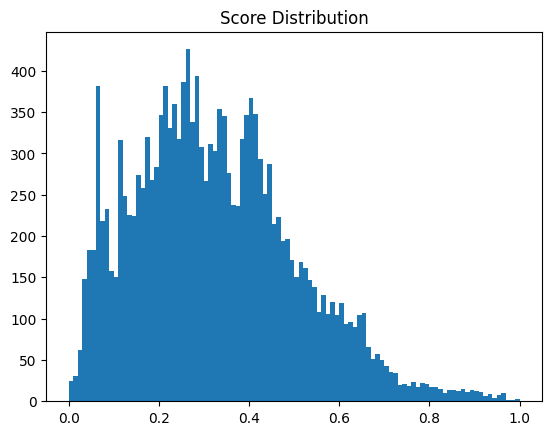

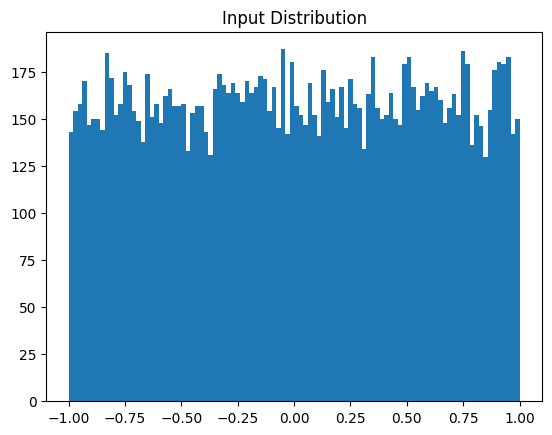

In [16]:
# Create dataset
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

with tf.device("cpu:0"):
    runs = pd.read_csv("game_runs.csv")[["Run", "Winner"]].sample(frac=1).values.tolist()
    all_frames = []
    all_next_frames = []
    all_input = []
    all_scores = []
    for run, winner in runs[:125]:
        frames = tf.cast(tf.io.parse_tensor(tf.io.read_file("runs/%d/frames.proto_tensor" % run), tf.uint8), tf.float16)/255.0
        all_frames.append(frames)
    
        if ROLE == "TAGGER":
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_inputs.proto_tensor" % run), float))
        else:
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_inputs.proto_tensor" % run), float))
    
        tagger_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_poses.proto_tensor" % run), float)
        taggee_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_poses.proto_tensor" % run), float)
    
        scores_normalizer = tf.math.sqrt(tf.cast(tf.math.square(IMG_INPUT_SHAPE[0]) + tf.math.square(IMG_INPUT_SHAPE[1]), float))
        
        if ROLE == "TAGGER":
            scores = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1))/scores_normalizer
        else:
            scores = (scores_normalizer - tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1)))/scores_normalizer
        
        if winner != ROLE:
            # Set all last scores to be 1
            # scores = tf.concat([scores[:-5:], tf.repeat(tf.constant([1.0]), repeats=5)], axis=0)
            
            # Make scores at the end more linear
            dist = 1.0 - scores[-5].numpy()
            smoothed_end = [scores[-10].numpy() + (dist / 5 * (i + 1)) for i in range(5)]
            scores = tf.concat([scores[:-5:], tf.constant(smoothed_end, float)], axis=0)

        all_scores.append(scores)
        print(run)

    all_next_frames = tf.concat([frame[1:] for frame in all_frames], axis=0)
    all_frames = tf.concat([frame[:-1] for frame in all_frames], axis=0)
    all_input = tf.cast(tf.concat([input[:-1] for input in all_input], axis=0), tf.float16)
    all_scores = tf.cast(tf.concat([score[:-1] for score in all_scores], axis=0), tf.float16)
    
    # # Normalize all scores and calc score deltas
    # new_all_scores = []
    # all_delta_scores = []
    
    # for scores in all_scores:
    #     scores = tf.expand_dims(scores, axis=-1)
    #     scores = tf.numpy_function(lambda x: RobustScaler().fit_transform(x), [scores], float)
    #     scores = (scores - tf.math.reduce_min(scores, keepdims=True)) / (tf.math.reduce_max(scores, keepdims=True) - tf.math.reduce_min(scores, keepdims=True))

    #     new_all_scores.append(scores[:-1])
    #     all_delta_scores.append(scores[1:] - scores[:-1])

    # all_scores = tf.cast(tf.concat(new_all_scores, axis=0), tf.float16)
    # all_delta_scores = tf.cast(tf.concat(all_delta_scores, axis=0), tf.float16)

    # Normalize scores
    all_scores = tf.expand_dims(all_scores, axis=-1)
    all_scores = tf.numpy_function(lambda x: RobustScaler().fit_transform(x), [all_scores], float)
    all_scores = (all_scores - tf.math.reduce_min(all_scores, keepdims=True)) / (tf.math.reduce_max(all_scores, keepdims=True) - tf.math.reduce_min(all_scores, keepdims=True))
    all_scores = tf.cast(all_scores, tf.float16)
    
    # Sum the inputs
    mult_inputs = tf.constant([[1, -1]], tf.float16)
    print(all_input.shape, mult_inputs.shape)
    all_input *= mult_inputs
    all_input = tf.math.reduce_sum(all_input, axis=-1, keepdims=True)
    
    print(tf.shape(all_frames), tf.shape(all_next_frames), tf.shape(all_input), tf.shape(all_scores)) #, tf.shape(all_delta_scores))
    print(tf.math.reduce_max(all_scores), tf.math.reduce_min(all_scores)) # , tf.math.reduce_max(all_delta_scores), tf.math.reduce_min(all_delta_scores))

    # Plot histogram of scores
    plt.hist(all_scores[:, 0].numpy(), bins=100)
    plt.title("Score Distribution")
    plt.show()

    # Plot histogram of input
    plt.hist(all_input[:, 0].numpy(), bins=100)
    plt.title("Input Distribution")
    plt.show()

    # plt.hist(all_delta_scores[:, 0].numpy(), bins=100)
    # plt.title("Delta Score Distribution")
    # plt.show()

    # Make DS
    big_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_next_frames, all_input, all_scores)) # , all_delta_scores))
    big_train_ds = big_train_ds.shuffle(big_train_ds.cardinality())
    big_valid_ds = big_train_ds.shard(8, 6)
    big_test_ds = big_train_ds.shard(8, 7)
    big_train_ds = big_train_ds.take((6 * big_train_ds.cardinality())//8)

In [10]:
# Train cost calculator and encoder
from tensorflow.keras import optimizers

# Comment out these two lines to train the encoder from scratch
encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE)
# encoder.trainable = False

enc_cost_calc = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE), encoder, cost_calculator])
enc_cost_calc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_LR), loss="mse", metrics=["mse"])
enc_cost_calc.summary()

frame_and_score = lambda w, x, y, z: (w, z)

enc_cost_calc.fit(
    big_train_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE),
    validation_data=big_valid_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE),
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

encoder.save("encoder_%s.keras" % ROLE)

encoder.trainable = False

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                889988    
                                                                 
 sequential_2 (Sequential)   (None, 1)                 15105     
                                                                 
Total params: 905093 (3.45 MB)
Trainable params: 904965 (3.45 MB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________
Epoch 1/200


2023-10-16 21:56:42.099660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-16 21:56:42.235799: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-10-16 21:56:42.235834: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-16 21:56:42.235941: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-16 21:56:43.303523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-16 21:56:43.328102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9a2d7d0 ini

741/741 [==============================] - 85s 97ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 9.3297e-04 - val_mse: 9.3297e-04
Epoch 5/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 7.0102e-04 - val_mse: 7.0102e-04
Epoch 6/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 7.7242e-04 - val_mse: 7.7242e-04
Epoch 7/200
741/741 [==============================] - 31s 42ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 7.4336e-04 - val_mse: 7.4336e-04
Epoch 8/200
741/741 [==============

In [11]:
# Train cost calculator without encoder and lower lr

# Comment out these two lines to train the cost_calculator from scratch
# cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)
# cost_calculator.trainable = False

cost_calculator.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_LR), loss="mse", metrics=["mse"])
cost_calculator.summary()

encodings_and_score = lambda w, x, y, z: (encoder(w), z)

encoding_cost_train_ds = big_train_ds.batch(BATCH_SIZE).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
encoding_cost_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

cost_calculator.fit(
    encoding_cost_train_ds,
    validation_data=encoding_cost_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

cost_calculator.save("cost_calculator_%s.keras" % ROLE)

cost_calculator.trainable = False

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)               

In [12]:
# Train prediction

def minimum_mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    mse = tf.math.reduce_mean(se, axis=2) # because axis 0 is batch and 1 is the 4 predictions
    return tf.math.reduce_mean(tf.math.reduce_min(mse, axis=1)) # because axis 0 is batch

def mse(y_true, y_pred):
    se = tf.math.square(tf.expand_dims(y_true, axis=1) - y_pred)
    return tf.math.reduce_mean(se)

with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: ((tf.cast(encoder(w), tf.float16), y), tf.cast(encoder(x), tf.float16))
    pred_train_ds = big_train_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
    pred_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

with tf.device("gpu:0"):
    predictor.compile(optimizers.Adam(learning_rate=PRED_LR), loss=minimum_mse, metrics=[minimum_mse, mse])
    predictor.summary()
    
    predictor.fit(
        pred_train_ds,
        validation_data=pred_valid_ds,
        epochs=MAX_EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
    )

predictor.trainable=False

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 64)                0         ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 tf.repeat (TFOpLambda)      (None, 2, 64)                0         ['tf.expand_dims[0][0]']      
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                      

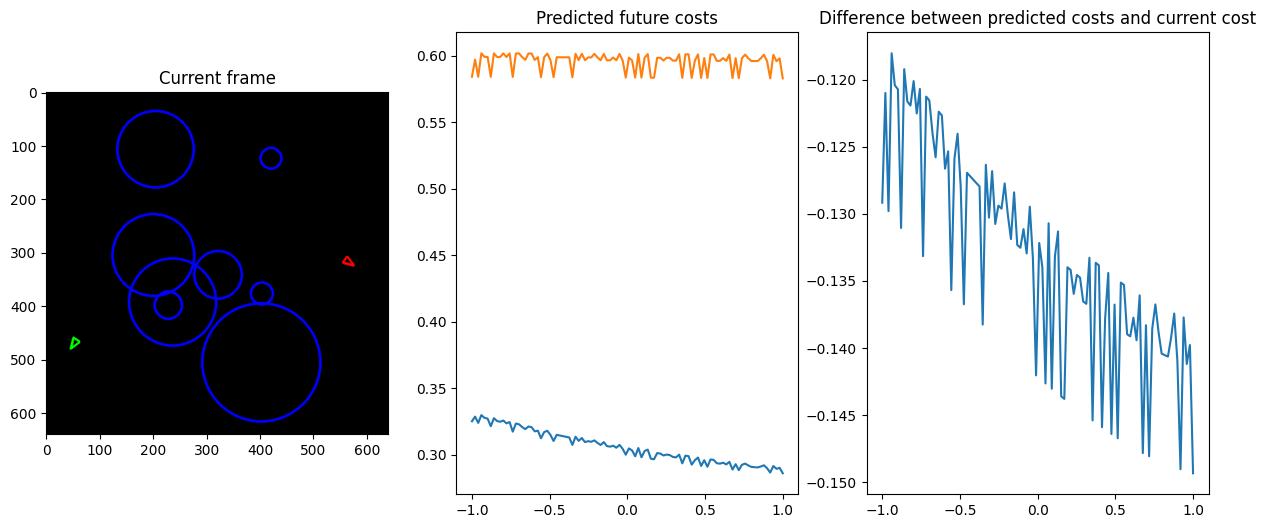

Real cost, calculated cost, difference 0.5996094 0.5839545 0.015654862
Caclulated next frame cost, predicted next frame cost cost, difference 0.60330576 [0.30719814 0.59874   ] [0.29610762 0.00456578]


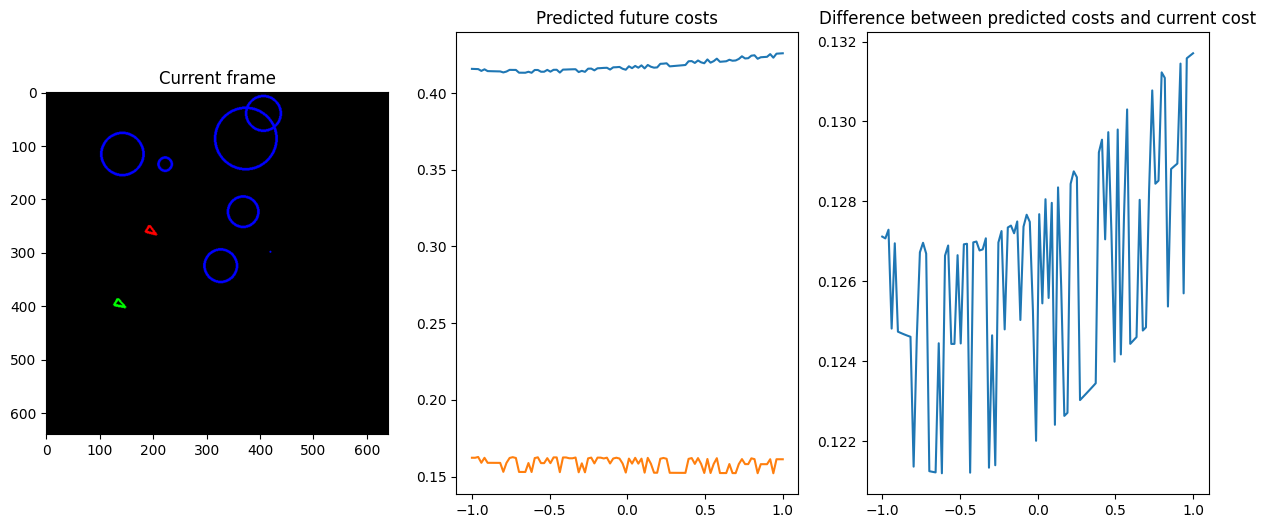

Real cost, calculated cost, difference 0.15222168 0.16190906 -0.009687379
Caclulated next frame cost, predicted next frame cost cost, difference 0.16469285 [0.4182726  0.15240484] [-0.25357977  0.012288  ]


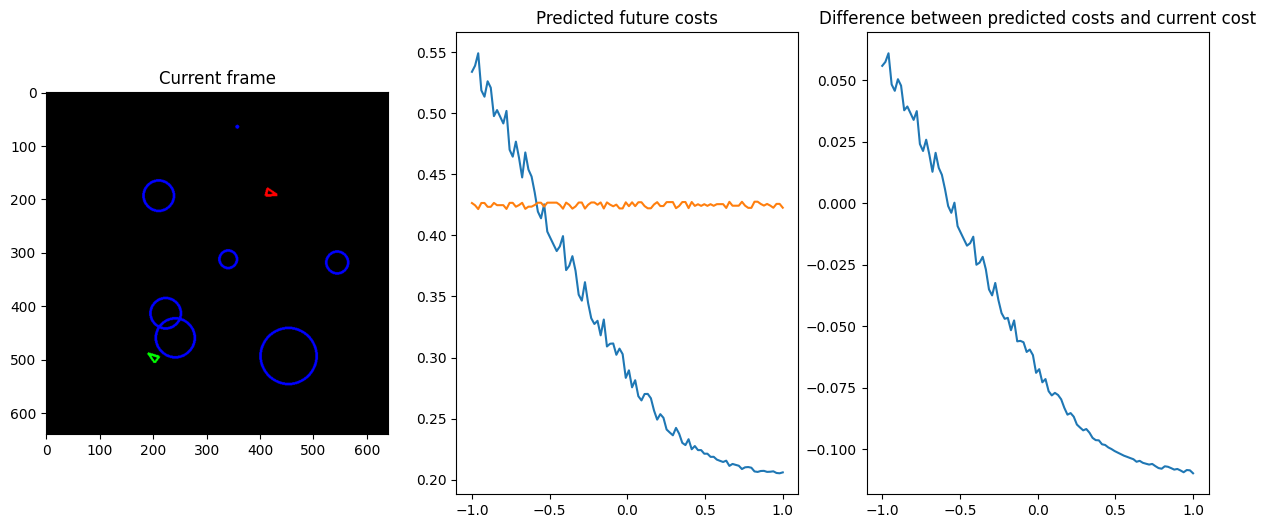

Real cost, calculated cost, difference 0.42236328 0.42413852 -0.0017752349
Caclulated next frame cost, predicted next frame cost cost, difference 0.4268255 [0.24716474 0.42217135] [0.17966075 0.00465414]


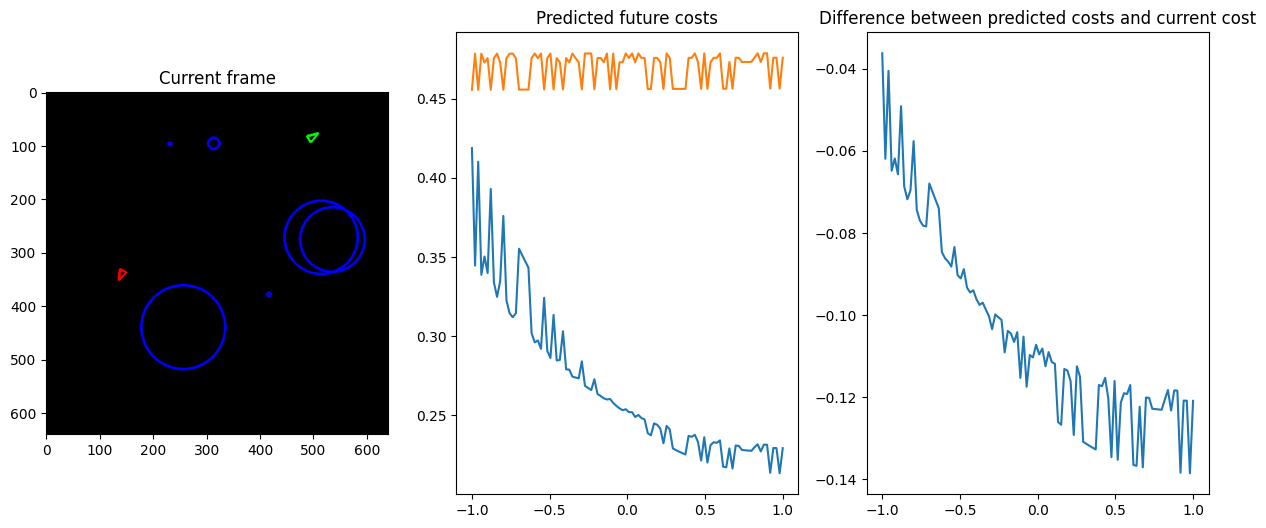

Real cost, calculated cost, difference 0.48291016 0.47345608 0.0094540715
Caclulated next frame cost, predicted next frame cost cost, difference 0.45992237 [0.25098032 0.47309038] [ 0.20894206 -0.01316801]


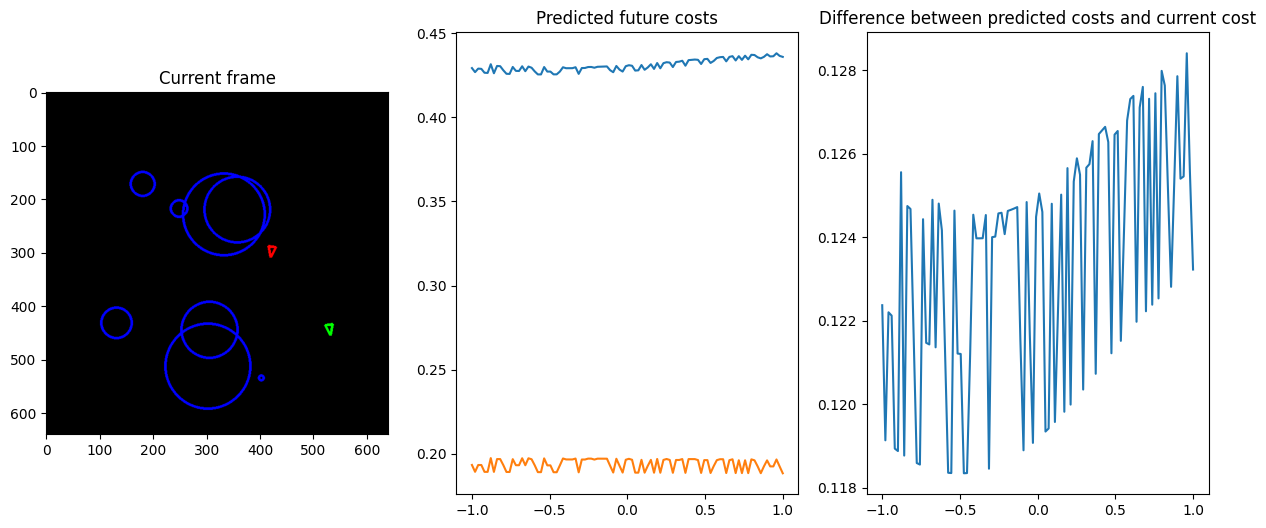

Real cost, calculated cost, difference 0.19042969 0.18893574 0.0014939457
Caclulated next frame cost, predicted next frame cost cost, difference 0.19931528 [0.42564097 0.18899351] [-0.22632569  0.01032177]


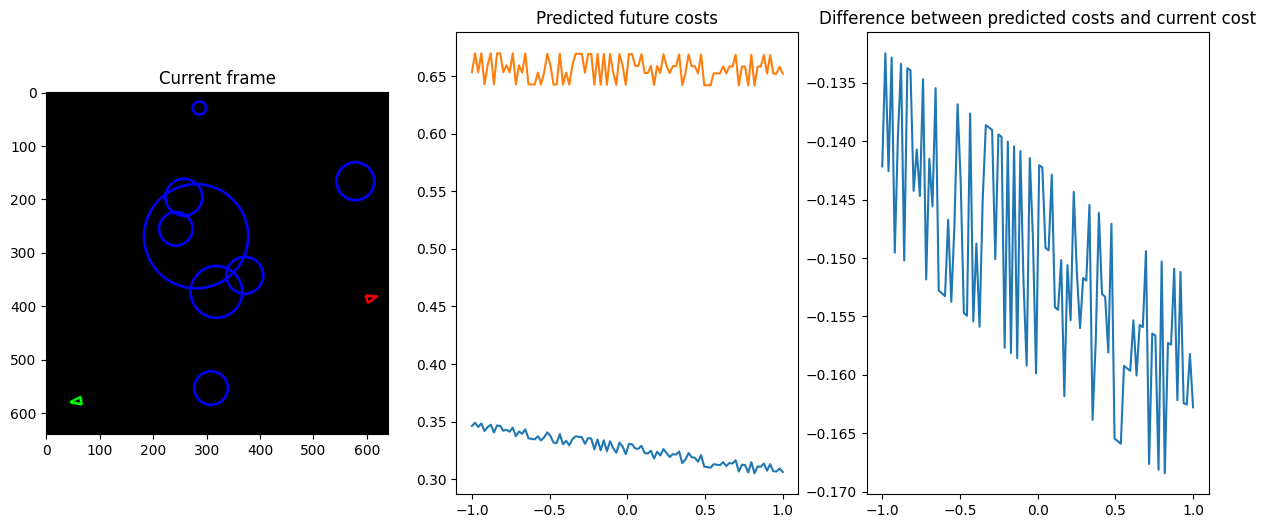

Real cost, calculated cost, difference 0.6513672 0.6419286 0.009438574
Caclulated next frame cost, predicted next frame cost cost, difference 0.649269 [0.30831262 0.6520678 ] [ 0.34095636 -0.0027988 ]


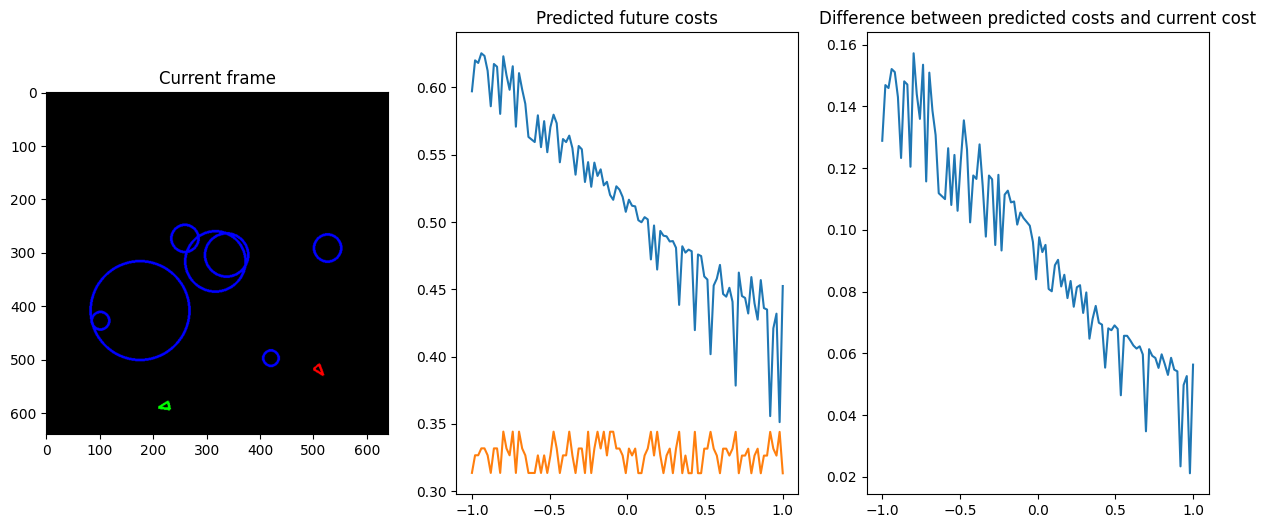

Real cost, calculated cost, difference 0.3149414 0.32646918 -0.011527777
Caclulated next frame cost, predicted next frame cost cost, difference 0.3347071 [0.45987725 0.34409612] [-0.12517014 -0.00938901]


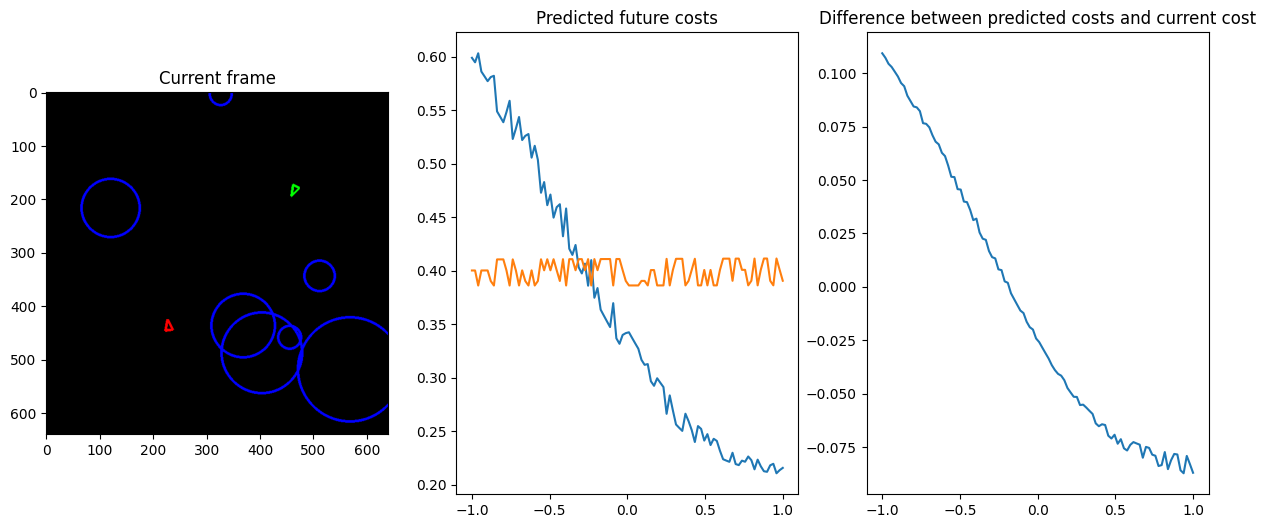

Real cost, calculated cost, difference 0.40356445 0.39007786 0.013486594
Caclulated next frame cost, predicted next frame cost cost, difference 0.38238868 [0.25080138 0.40054733] [ 0.1315873  -0.01815864]


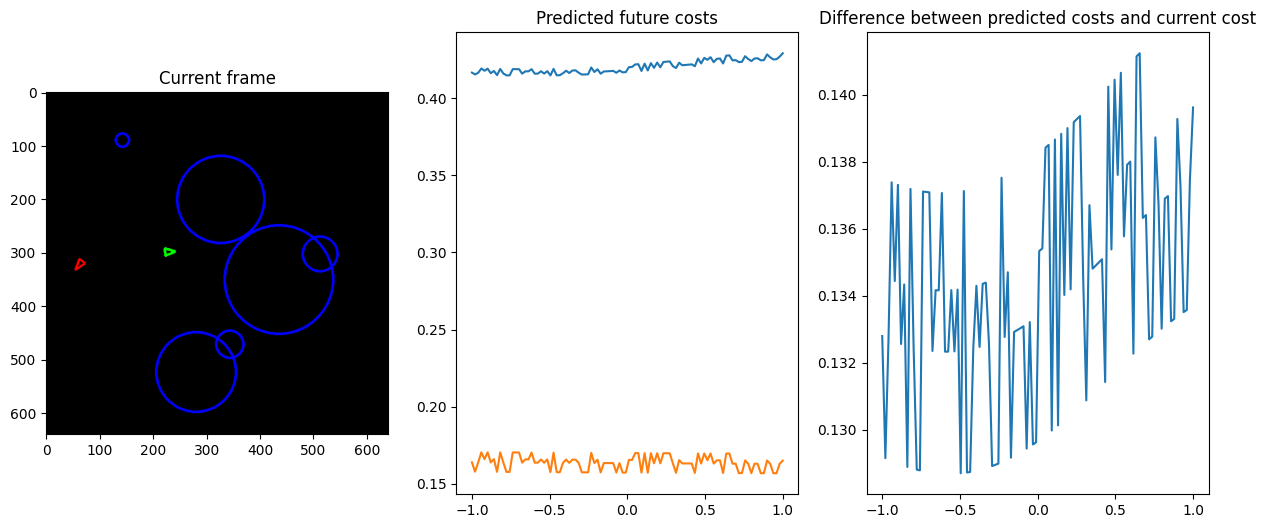

Real cost, calculated cost, difference 0.16101074 0.15746967 0.0035410672
Caclulated next frame cost, predicted next frame cost cost, difference 0.16911931 [0.4173299  0.16343865] [-0.2482106   0.00568067]


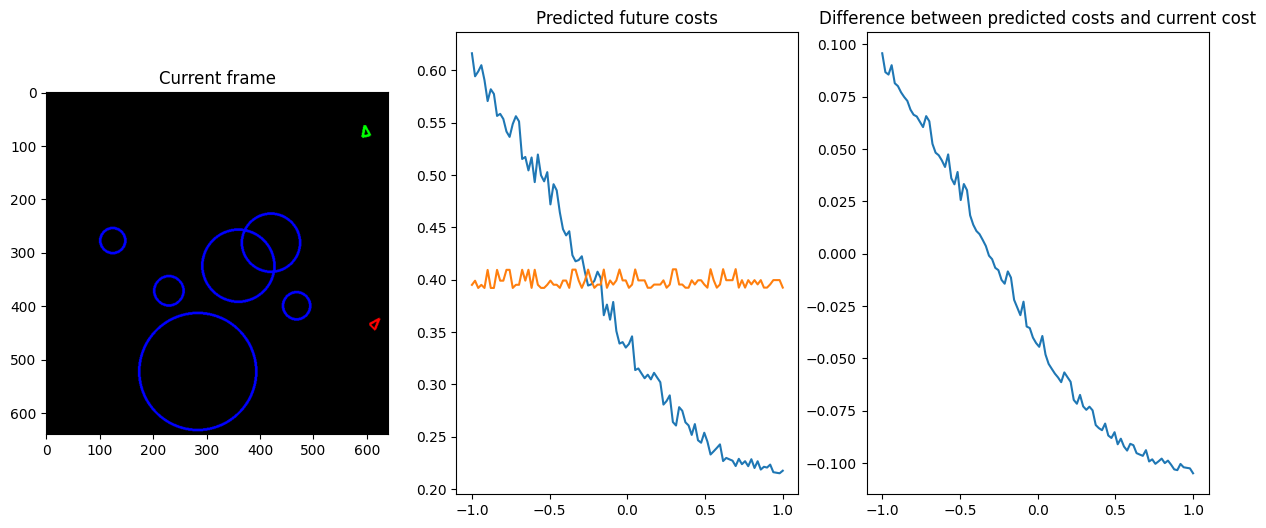

Real cost, calculated cost, difference 0.4013672 0.40988725 -0.008520067
Caclulated next frame cost, predicted next frame cost cost, difference 0.41139618 [0.34285587 0.4097679 ] [0.0685403  0.00162828]


In [13]:
# Plot sanity test: how does turning effect score
import matplotlib.pyplot as plt

test_cc_ds = big_valid_ds.take(10)

# cost_calculator(predictor(
for element in test_cc_ds:
    fig, ax = plt.subplots(1, 3, figsize=(15,6))
    ax[0].imshow(element[0].numpy().astype(float))
    ax[0].set_title("Current frame")

    actions = tf.expand_dims(tf.linspace(-1, 1, 100), axis=-1)
    act_results = tf.map_fn(lambda x: cost_calculator(predictor((encoder(tf.expand_dims(element[0], axis=0)), x))[0, :, :]), actions, fn_output_signature=float)
    ax[1].plot(actions[:, 0], act_results[:, :, 0])
    ax[1].set_title("Predicted future costs")
    
    real_cost = tf.cast(element[3][0], float)
    calc_cost = cost_calculator(encoder(tf.expand_dims(element[0], axis=0)))[0, 0]
    
    ax[2].plot(actions[:, 0], tf.reduce_mean(act_results[:, :, 0], axis=-1) - calc_cost)
    ax[2].set_title("Difference between predicted costs and current cost")
    plt.show()
    
    print("Real cost, calculated cost, difference", real_cost.numpy(), calc_cost.numpy(), (real_cost - calc_cost).numpy())

    calc_next_cost = cost_calculator(encoder(tf.expand_dims(element[1], axis=0)))[:, 0]
    pred_next_cost = cost_calculator(predictor((encoder(tf.expand_dims(element[0], axis=0)), element[2]))[0, :, :])[:, 0]

    print("Caclulated next frame cost, predicted next frame cost cost, difference", calc_next_cost[0].numpy(), pred_next_cost.numpy(), (calc_next_cost - pred_next_cost).numpy())

In [ ]:
# Train action generator
def minimize_loss(y_true, y_pred):
    return tf.math.reduce_mean(y_pred)

with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: (tf.cast(encoder(w), tf.float16), z)
    actgen_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=BATCH_SIZE//4, deterministic=False).cache()
    actgen_train_ds = tf.data.Dataset.from_tensor_slices((tf.random.normal((100_000, OUTPUT_SIZE)), tf.zeros(100_000, 1))).batch(BATCH_SIZE)

print(actgen_train_ds)
print(actgen_valid_ds)

model_in = layers.Input(shape=(OUTPUT_SIZE))
action_gen_trainer = predictor((model_in, action_gen(model_in)))
action_gen_trainer = tf.reshape(action_gen_trainer, (tf.shape(action_gen_trainer)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
action_gen_trainer = cost_calculator(action_gen_trainer)
action_gen_trainer = tf.math.reduce_mean(tf.reshape(action_gen_trainer, (tf.shape(action_gen_trainer)[0] // PRED_POSSIBLE_OUTCOMES, PRED_POSSIBLE_OUTCOMES, 1)), axis=1)
action_gen_trainer = models.Model(model_in, action_gen_trainer)

action_gen_trainer.compile(optimizers.Adam(learning_rate=ACT_GEN_LR), loss=minimize_loss, metrics=[minimize_loss])
action_gen_trainer.summary(show_trainable=True)

action_gen_trainer.fit(
    actgen_train_ds,
    validation_data=actgen_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.float16, name=None), TensorSpec(shape=(None, 1), dtype=tf.float16, name=None))>
Model: "model_2"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_9 (InputLayer)        [(None, 64)]                 0         []                            Y          
                                                                                                             
 sequential_3 (Sequential)   (None, 1)                    8113153   ['input_9[0][0]']             Y          
                                                                                                             
 model_1 (Functional)        (No

In [17]:
# Save model so it can play the game

pred_model = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE), encoder, action_gen])
pred_model.save("prediction_model_%s.keras" % ROLE)